### Создание и обучение модели для сегментации

In [38]:
#!g1.1
import numpy as np 
import time
import random
import os

import tensorflow as tf
from tensorflow.keras.models import Model       
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import Reshape, GlobalAveragePooling2D, UpSampling2D, AveragePooling2D
from tensorflow.keras import backend as K        
from tensorflow.keras.optimizers import Adam     
from tensorflow.keras import utils               
from tensorflow.keras.preprocessing import image 
from sklearn.model_selection import train_test_split
from keras.models import load_model

import matplotlib.pyplot as plt  
# from PIL import Image 

In [39]:
#!g1.1
SEED = 1111
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [40]:
#!g1.1
# Путь к сохраненным выборкам
data_path = "/home/jupyter/work/resources/NIIAS-RZD/data_np"
# Путь для сохранения моделей
model_path = "/home/jupyter/work/resources/NIIAS-RZD/models"

In [41]:
#!g1.1
# Список выборок
np_files  = []
for file_name in sorted(os.listdir(data_path)):
    if 'data' in file_name:
        np_files.append(file_name)
print("Имеем {} сохраненных выборок".format(len(np_files)))

Имеем 30 сохраненных выборок


In [42]:
#!g1.1
# Загрузим пример сохраненной выборки
np_file = random.choice(np_files)
print(np_file)
data = np.load(os.path.join(data_path, np_file))
images_np = data['a']
anns_np = data['b']
print(images_np.shape, anns_np.shape)

data07.npz
(800, 432, 768, 3) (800, 432, 768, 4)


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: data
  warnings.warn(message)


In [43]:
#!g1.1
# Размеры, изображения
img_height = images_np.shape[1]      # 432
img_width = images_np.shape[2]       # 768
print(img_height, img_width)

432 768


In [44]:
#!g1.1
# Классов сегментации
classes = [0, 6, 7, 10]
num_classes = len(classes)
print(num_classes)

4


### Создание PSP-net

<img src="./PSPNet.png" width=800 heigth=480>

In [45]:
#!g1.1
# Функция метрики, обрабатывающая пересечение двух областей
def dice_coef(y_true, y_pred):
  # Возвращаем площадь пересечения деленную на площадь объединения двух областей
  return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) 

In [46]:
#!g1.1
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def pspnet(num_classes = 4, input_shape= (432, 768, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Feature Map
    x = Conv2D(64, (3, 3), padding='same', name='feature_map_conv1')(img_input)  # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                                  # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                    # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='feature_map_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                                  # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                    # Добавляем слой Activation
 
    x = Conv2D(256, (3, 3), padding='same', name='feature_map_conv3')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                                  # Добавляем слой BatchNormalization
    feature_map_out = Activation('relu', name='feature_map_out')(x)              # Добавляем слой Activation 
 

    # Pyramyd Pooling Module
    # red
    #red = GlobalAveragePooling2D(name='red_pool')(feature_map_out)
    #red = Reshape((1,1,256))(red)
    red = AveragePooling2D(pool_size=(1,1),name='red_pool')(feature_map_out)
    red = Conv2D(filters=64,kernel_size=(1,1),name='red_conv')(red)
    #red = UpSampling2D(size=256,interpolation='bilinear',name='red_upsampling')(red)
    red = UpSampling2D(size=1,interpolation='bilinear',name='red_upsampling')(red)

    # yellow
    yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(feature_map_out)
    yellow = Conv2D(filters=64,kernel_size=(1,1),name='yellow_conv')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)

    # blue
    blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(feature_map_out)
    blue = Conv2D(filters=64,kernel_size=(1,1),name='blue_conv')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)

    # green
    green = AveragePooling2D(pool_size=(8,8),name='green_pool')(feature_map_out)
    green = Conv2D(filters=64,kernel_size=(1,1),name='green_conv')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)

    # feature_map + red + yellow + blue + green
    pooling_module_out = concatenate([feature_map_out,red,yellow,blue,green])


    # Final Prediction
    x = Conv2D(64, (3, 3), padding='same')(pooling_module_out)                   # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                                  # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                    # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)     # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [25]:
#!g1.1
# Создаем модель и сохраняем ее 
modelPSPnet = pspnet(num_classes, (img_height, img_width, 3))
# modelPSPnet.summary()

model_file = os.path.join(model_path, '00-PSPNet')
modelPSPnet.save(model_file, save_format='tf')

INFO:tensorflow:Assets written to: /home/jupyter/work/resources/NIIAS-RZD/models/00-PSPNet/assets


In [47]:
#!g1.1
# Обучаем на нескольких выборках
N_np = 10
start_from = 21 # нумерации файлов 

history_list = []

# Загружаем модель (поправить вручную)
model_file = os.path.join(model_path, '20-PSPNet')
modelPSPnet = load_model(model_file, custom_objects={'dice_coef':dice_coef})

cur_time = time.time()
for n in range(N_np):
    np_file = np_files[start_from + n - 1]
    data = np.load(os.path.join(data_path, np_file))
    images_np = data['a']
    anns_np = data['b']
    print("\nОбучение на выборке {}".format(np_file))
    
    x_train, x_val, y_train, y_val = train_test_split(images_np, anns_np, test_size=0.15, shuffle=True)   
    
    history = modelPSPnet.fit(x_train, y_train, epochs=10, batch_size=2, validation_data = (x_val, y_val)) 
    history_list.append(history)
    
    file_number = "%02d" % (start_from + n)
    model_file = os.path.join(model_path, file_number + '-PSPNet')
    modelPSPnet.save(model_file, save_format='tf')
    
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

340/340 [==============================] - 72s 213ms/step - loss: 0.4087 - dice_coef: 0.7934 - val_loss: 0.4868 - val_dice_coef: 0.7843
Epoch 5/10
340/340 [==============================] - 72s 212ms/step - loss: 0.4138 - dice_coef: 0.7904 - val_loss: 0.4817 - val_dice_coef: 0.7892
Epoch 6/10
340/340 [==============================] - 72s 212ms/step - loss: 0.4086 - dice_coef: 0.7939 - val_loss: 0.5265 - val_dice_coef: 0.7871
Epoch 7/10
340/340 [==============================] - 72s 212ms/step - loss: 0.4097 - dice_coef: 0.7924 - val_loss: 0.4922 - val_dice_coef: 0.7589
Epoch 8/10
340/340 [==============================] - 72s 213ms/step - loss: 0.4063 - dice_coef: 0.7941 - val_loss: 0.4837 - val_dice_coef: 0.7955
Epoch 9/10
340/340 [==============================] - 72s 212ms/step - loss: 0.4087 - dice_coef: 0.7938 - val_loss: 0.4889 - val_dice_coef: 0.7775
Epoch 10/10
340/340 [==============================] - 72s 213ms/step - loss: 0.4078 - dice_coef: 0.7934 - val_loss: 0.4955 - val

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: data, history, history_list, modelPSPnet
  warnings.warn(message)


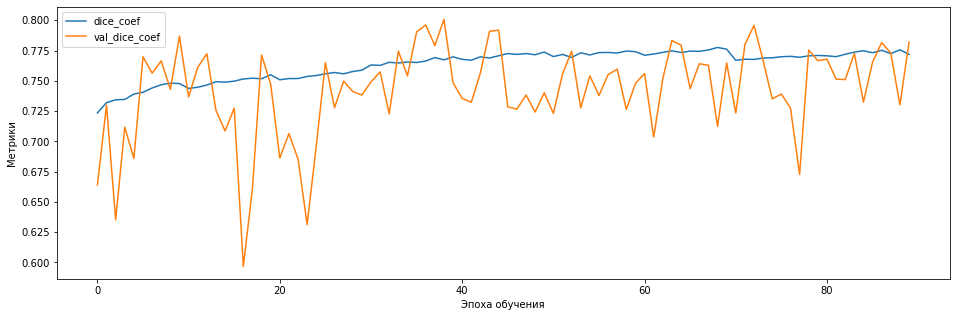

Максимальная точность val_dice_coef = 0.8008 на эпохе 38.


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: history, history_list, modelPSPnet
  warnings.warn(message)


In [34]:
#!g1.1
#Отображаем график точности в процессе обучения
history_acc = []
history_val = []
for N in range(len(history_list)):
    history_acc = history_acc + history_list[N].history['dice_coef']
    history_val = history_val + history_list[N].history['val_dice_coef']

plt.figure(figsize=(16,5))
plt.plot(history_acc, 
         label='dice_coef')
plt.plot(history_val, 
         label='val_dice_coef')
plt.xlabel('Эпоха обучения')
plt.ylabel('Метрики')
plt.legend()
plt.show()

# Максимальная точность
val_acc = np.array(history_val)
print('Максимальная точность val_dice_coef = {} на эпохе {}.'.format(round(val_acc.max(),4), val_acc.argmax()))
